In [8]:
import numpy as np
import pandas as pd

from collab2.foraging.toolkit import (
    dataObject,
    generate_local_windows,
    plot_predictor,
    rescale_to_grid,
    velocity_predictor_contribution
)

import matplotlib.pyplot as plt

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

# add nan values
nan_ind = np.random.randint(0, num_frames * num_foragers, size=n_nans)
foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# remove values for certain time points
drop_ind = np.random.randint(0, num_frames * num_foragers, size=n_missing)
foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size, frames=num_frames)

display(foragers_object.foragersDF)

/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:50: UserWarning: Missing frames encountered for forager 0, adding NaN fillers.
                    Specify handling of missing data using `skip_incomplete_frames` argument to
                    `generate_all_predictors`
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:50: UserWarning: Missing frames encountered for forager 1, adding NaN fillers.
                    Specify handling of missing data using `skip_incomplete_frames` argument to
                    `generate_all_predictors`
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:50: UserWarning: Missing frames encountered

,x,y,time,forager
0,NaN,NaN,0,0.0
1,28.0,10.0,1,0.0
2,13.0,0.0,2,0.0
3,5.0,7.0,3,0.0
4,17.0,18.0,4,0.0
5,15.0,16.0,5,0.0
6,NaN,NaN,6,0.0
7,19.0,10.0,7,0.0
8,NaN,NaN,0,1.0
9,13.0,7.0,1,1.0


In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 8,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

In [10]:
v_pred = velocity_predictor_contribution(3,0,foragers_object.foragers[0].query("time==1")["x"].values,foragers_object.foragers[0].query("time==1")["y"].values,local_windows[0][1],1,1 )

In [12]:
a = local_windows[0][1]
a["v_pred"] = v_pred

test_pred = [[a]]

KeyError: 0

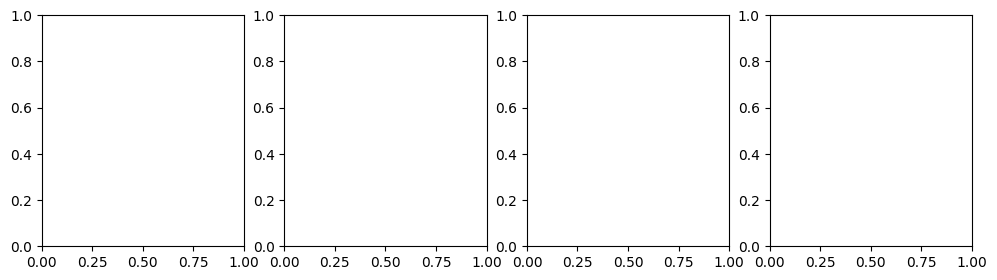

In [15]:
plot_predictor(
    foragers_object.foragers,
    a,
    "V_pred",
    [0],
    [0],
    30,
    size_multiplier=2,
    random_state=10,
)